# Sampta Experience II

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import torch_harmonics as th
import spherical_inr as sph
from sklearn.preprocessing import MinMaxScaler
import pyshtools

In [18]:
def compute_snr(image, noisy_image):
    """
    Computes the Signal-to-Noise Ratio (SNR) between two images.
    """
    
    signal_power = torch.mean(torch.square(image))
    noise_power = torch.mean(torch.square(image - noisy_image))
    snr = 10 * torch.log10(signal_power / noise_power)
    
    return snr

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Data Preprocessing 

In [5]:
coefficients = pyshtools.datasets.Earth.Earth2014.tbi(lmax = 100)

In [9]:
N_train = 2500
phi_train, theta_train = sph.sample_s2_uniform(N_train, torch_tensor = True)
data_train = coefficients.expand(lon = phi_train.numpy().flatten(),  colat = theta_train.numpy().flatten(), degrees=False, nthreads=0).flatten()


N_val = 2000
phi_val, theta_val = sph.sample_s2_uniform(N_val, torch_tensor = True)
data_val = coefficients.expand(lon = phi_val.numpy().flatten(),  colat = theta_val.numpy().flatten(), degrees=False, nthreads=0).flatten()

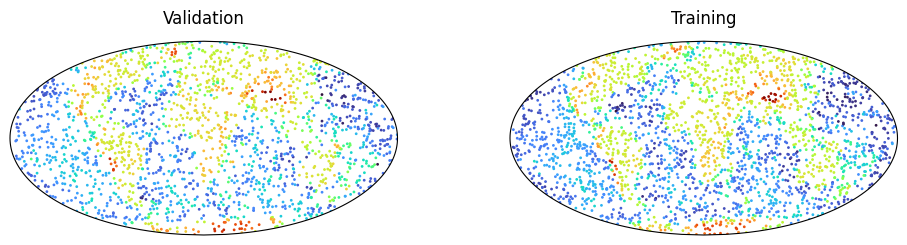

In [10]:
fig = plt.figure(figsize=(10, 5))
subfigs = fig.subfigures(1, 2)

sph.plot_sphere_scatter(data_train, lon = phi_train, lat = theta_train, molweide=True, cmap = "turbo", title = "Training", fig = subfigs[1], s = 1)
sph.plot_sphere_scatter(data_val, lon = phi_val, lat = theta_val, molweide=True, cmap = "turbo", title = "Validation", fig = subfigs[0], s = 1)
plt.show()

In [13]:
scaler = MinMaxScaler()
data_train_scaled = scaler.fit_transform(data_train.reshape(-1, 1)).flatten()

X = torch.stack([theta_train.flatten(), phi_train.flatten()], dim=-1).float()
y = torch.tensor(data_train_scaled.copy()).flatten().unsqueeze(1).float()

X_val = torch.stack([theta_val.flatten(), phi_val.flatten()], dim=-1).float()
y_val = torch.tensor(data_val.copy()).flatten().unsqueeze(1).float() # No scaling for validation data


X, X_val = X.to(device), X_val.to(device)
y, y_val = y.to(device), y_val.to(device)

## Model Parameter

In [14]:
Q = 3                   # number of hidden layer
L = 10                  # maximum frequency of embdedding
hidden_features = 50    # number of hidden features

In [20]:
degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
supports = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0]

In [23]:
N_EXP = 5
SNRs = {f"{d}": [] for d in degrees}


for d, supp in zip(degrees, supports) :
    for _ in range(N_EXP):

        model = sph.SphericalNet(
            Q  = Q, 
            L0 = L,
            hidden_features = hidden_features,
            bias = False, 
            activation = sph.Chebyshev(order = d, alpha = supp),
            spectral_norm = True, 
            device = device
        )


        sph.train(
            model = model, 
            x = X,
            y = y,
            epochs = 100,
            batch_size = 512,
            optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
            loss_fn = torch.nn.MSELoss(),
        )

        y_pred = model(X_val).detach().cpu().numpy().flatten()
        y_pred_scaled = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        SNRs[f"{d}"].append(compute_snr(y_val, y_pred_scaled))

KeyboardInterrupt: 

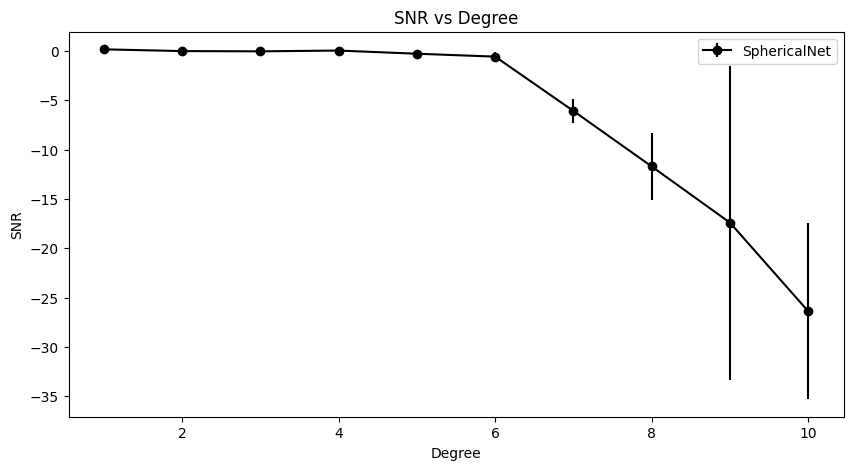

In [ ]:
fig = plt.figure(figsize=(10, 5))

means = [np.mean(SNRs[f"{d}"]) for d in degrees]
stds = [np.std(SNRs[f"{d}"]) for d in degrees]

plt.errorbar(degrees, means, yerr=stds, fmt='o-', label="SphericalNet", color = "k")
plt.title("SNR vs Degree")
plt.xlabel("Degree")
plt.ylabel("SNR")
plt.legend()
plt.show()
